In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

import glob
import json


In [3]:
# Edit Distance
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

# Data Input and Parameter Setting

In [4]:
parameter_all = []
intersect_all = []
dataset_list = ['stsb', 'snli']
embedding_list = ['mpnet', 'MiniLM']
checkpoint_list = [0,1,2,3,4,5,6,7,8,9,10]
query_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [6]:
dataset_idx = 0
embedding_idx = 0
checkpoint_idx = 0
query_idx = 1 # Which query


## Generate results for all parameter combinations

In [16]:
# For data input, please refer to "Read Saved Data!"
# Query feature vector: /text-dna/data/queries/features-stsb-MiniLM.h5
# where stsb is dataset, MiniLM is language model,

# Target feature vector: /text-dna/data/open_sbert/targets/features/targets-stsb-MiniLM.h5
# the format is the same as above.

# Query DNA sequence: /text-dna/data/queries/feature_seqs-stsb-MiniLM-0.h5
# where stsb is dataset, MiniLM is language model, 0 is the training epoch of encoder training.

# Target DNA sequence: /text-dna/data/targets/feature_seqs-stsb-MiniLM-0.h5
# the format is the same as above.

for dataset_idx in range(0,2):
    for embedding_idx in range(0,2):
        for checkpoint_idx in range(0,11):
            for query_idx in range(0,9):
                try:
                    # ---------- Data Input ----------
                    query_vector_addr = './new_data/vector/query/features-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] + '.h5'
                    query_seq_addr = './new_data/sequence/query/feature_seqs-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] +'-'+ str(checkpoint_list[checkpoint_idx]) + '.h5'
                    target_vector_addr = './new_data/vector/target/targets-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] + '.h5'
                    target_seq_addr = './new_data/sequence/target/feature_seqs-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] +'-'+ str(checkpoint_list[checkpoint_idx]) + '.h5'

                    dataset_addr = './new_data/' + dataset_list[dataset_idx] + '-target.json'

                    with open(dataset_addr, 'r') as f: # snli-target.json
                        parsed = json.load(f)
                    dataset = parsed.copy()
                    if dataset_idx == 0: # stsb 
                        index_list = ['sentence1-{}'.format(i) for i in range(len(dataset) / 2)] + ['sentence2-{}'.format(i) for i in range(len(dataset) / 2)]
                    else: # snli
                        index_list = ['hypothesis-{}'.format(i) for i in range(len(dataset) / 2)] + ['premise-{}'.format(i) for i in range(len(dataset) / 2)]

                    sentence_all = np.array([dataset[x] for x in index_list])

                    # # Feature Vector Input
                    query_text = pd.read_hdf(query_vector_addr).values
                    target_text = pd.read_hdf(target_vector_addr).values

                    # # DNA Sequence Input
                    query_seqs = pd.read_hdf(query_seq_addr)
                    target_seqs = pd.read_hdf(target_seq_addr)
                    # print(query_text.shape, target_text.shape, query_seqs.shape, target_seqs.shape)
                    # e.g., ((9, 768), (2758, 768), (9, 1), (2758, 1))

                    # ---------- Calculate Distance to Query ----------


                    # Sequence Edit Distance
                    query_dis = []
                    for i in target_seqs.values:
                        query_dis.append(levenshteinDistance(query_seqs.values[query_idx][0], i[0]))    
                    query_dis = np.array(query_dis)

                    # Feature vector euclidean distance
                    query_dis_feature = []
                    for i in target_text:
                        query_dis_feature.append(pairwise_distances(query_text[query_idx].reshape(1, -1), 
                                                            i.reshape(1, -1), 
                                                            metric = 'euclidean')[0][0])
                    query_dis_feature = np.array(query_dis_feature)


                    # # Plot
                    # fig,ax = plt.subplots()

                    # ax.plot(query_dis[np.argsort(query_dis)], color = 'b') # , label = 'DNA Sequence'
                    # ax.set_ylabel('Edit Distance of DNA Sequence', color = 'b')
                    # ax.set_xlabel('Index of Target (from Near to Far)')
                    # ax.set_ylim(bottom=0)

                    # ax2 = ax.twinx()
                    # ax2.plot(query_dis_feature[np.argsort(query_dis_feature)], color = 'y') # , label = 'Feature Vector'
                    # ax2.set_ylabel('Euclidean Distance of Feature Vector', color = 'y')
                    # ax2.set_ylim(bottom=0)



                    # ---------- Output Intersection (Vector NN & Sequence NN) ----------
                    # print(dataset_idx, embedding_idx, checkpoint_idx, query_idx)
                    intersect_tmp = []
                    for num_k in [1, 10, 50, 100, 500, 1000, 2000]:
                        intersect_idx = np.intersect1d(np.argsort(query_dis)[0:num_k], np.argsort(query_dis_feature)[0:num_k])
                        intersect_tmp.append(len(intersect_idx)* 1.0/num_k)
                        # print(len(intersect_idx)* 1.0/num_k)


                    parameter_all.append([dataset_idx, embedding_idx, checkpoint_idx, query_idx])    
                    intersect_all.append(intersect_tmp)
                    print(dataset_idx, embedding_idx, checkpoint_idx, query_idx) 
                except:
                    parameter_all.append([dataset_idx, embedding_idx, checkpoint_idx, query_idx])    
                    intersect_all.append([-1, -1, -1, -1, -1, -1, -1])
                    print(dataset_idx, embedding_idx, checkpoint_idx, query_idx)


(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 0, 3)
(0, 0, 0, 4)
(0, 0, 0, 5)
(0, 0, 0, 6)
(0, 0, 0, 7)
(0, 0, 0, 8)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 1, 3)
(0, 0, 1, 4)
(0, 0, 1, 5)
(0, 0, 1, 6)
(0, 0, 1, 7)
(0, 0, 1, 8)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 0, 2, 2)
(0, 0, 2, 3)
(0, 0, 2, 4)
(0, 0, 2, 5)
(0, 0, 2, 6)
(0, 0, 2, 7)
(0, 0, 2, 8)
(0, 0, 3, 0)
(0, 0, 3, 1)
(0, 0, 3, 2)
(0, 0, 3, 3)
(0, 0, 3, 4)
(0, 0, 3, 5)
(0, 0, 3, 6)
(0, 0, 3, 7)
(0, 0, 3, 8)
(0, 0, 4, 0)
(0, 0, 4, 1)
(0, 0, 4, 2)
(0, 0, 4, 3)
(0, 0, 4, 4)
(0, 0, 4, 5)
(0, 0, 4, 6)
(0, 0, 4, 7)
(0, 0, 4, 8)
(0, 0, 5, 0)
(0, 0, 5, 1)
(0, 0, 5, 2)
(0, 0, 5, 3)
(0, 0, 5, 4)
(0, 0, 5, 5)
(0, 0, 5, 6)
(0, 0, 5, 7)
(0, 0, 5, 8)
(0, 0, 6, 0)
(0, 0, 6, 1)
(0, 0, 6, 2)
(0, 0, 6, 3)
(0, 0, 6, 4)
(0, 0, 6, 5)
(0, 0, 6, 6)
(0, 0, 6, 7)
(0, 0, 6, 8)
(0, 0, 7, 0)
(0, 0, 7, 1)
(0, 0, 7, 2)
(0, 0, 7, 3)
(0, 0, 7, 4)
(0, 0, 7, 5)
(0, 0, 7, 6)
(0, 0, 7, 7)
(0, 0, 7, 8)
(0, 0, 8, 0)
(0, 0, 8, 1)
(0, 0, 8, 2)
(0, 0, 8, 3)
(0, 0, 8, 4)

In [8]:
import pickle

In [18]:

with open('parameter_all.pkl', 'wb') as f:
     pickle.dump(parameter_all, f)
        
with open('intersect_all.pkl', 'wb') as f:
     pickle.dump(intersect_all, f)        

In [9]:
with open('parameter_all.pkl', 'rb') as f:
    parameter_all = pickle.load(f)

with open('intersect_all.pkl', 'rb') as f:
    intersect_all = pickle.load(f)

# Analysis

In [10]:
parameter_all = np.array(parameter_all)
intersect_all = np.array(intersect_all)

In [11]:
np.sum(parameter_all[:,0] == 0)

201

In [12]:
np.sum(parameter_all[:,0] == 1)

198

In [13]:
color_all  = np.array(['red', 'blue', 'green', 'purple', 'deepskyblue', 'darkorange', 
    'olive', 'deeppink', 'dodgerblue', 'dimgray', 'lime', 'pink'])
marker_all = np.array(['o', '^', 's', 'd', '*', 'p', 'x', 'v', 'D', '>'])

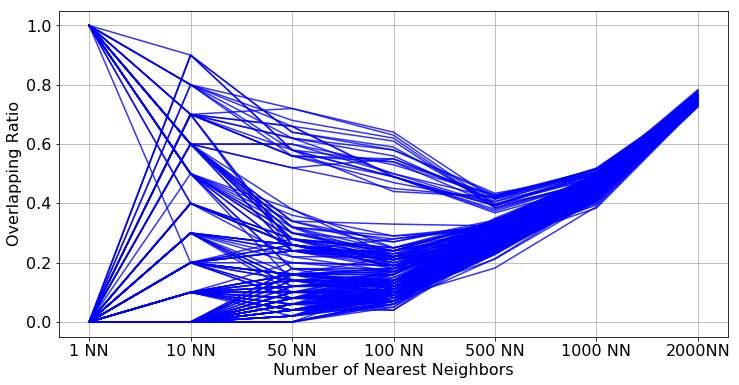

In [166]:
(fig, ax) = plt.subplots(figsize=(12, 6))
plt.setp(ax, xticks=[0, 1, 2, 3, 4, 5, 6], 
         xticklabels=['1 NN', '10 NN', '50 NN', '100 NN', '500 NN', '1000 NN', '2000NN'])
         # yticks=[1, 2, 3])

# ax = subplots[plot_result]
# feature_label = feature_label_all[plot_result]
# feature_color = parameter_all[0:201][:,plot_result + 1]


# fig, ax = plt.subplots(figsize = (12,6))


# ax.set_color_cycle(color_all[feature_color])
# ax.set_title(title_all[plot_result])

g1_plot = ax.plot(intersect_all[0:201].T, alpha = 0.8, c = 'blue')

g1 = ax.grid()
g1 = ax.set_xlabel('Number of Nearest Neighbors', fontsize = 16)
g1 = ax.set_ylabel('Overlapping Ratio', fontsize = 16)
g1 = ax.set_ylim(-0.05, 1.05)
g1 = ax.tick_params(axis='both', which='major', labelsize=16)


plt.savefig('all_parameters.pdf',dpi=600,format='pdf', bbox_inches = 'tight')

/home/yihao/anaconda3/envs/py3/lib/python2.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.


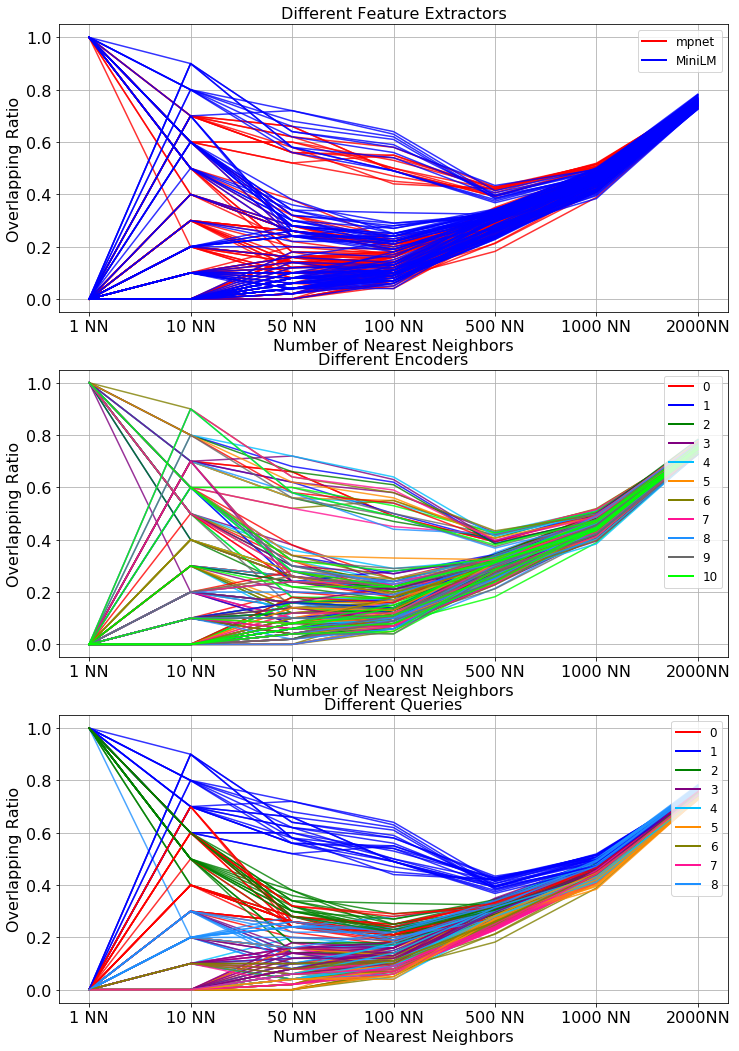

In [173]:
(fig, subplots) = plt.subplots(3, 1, figsize=(12, 6*3))

plt.setp(subplots, xticks=[0, 1, 2, 3, 4, 5, 6], 
         xticklabels=['1 NN', '10 NN', '50 NN', '100 NN', '500 NN', '1000 NN', '2000NN'])
         # yticks=[1, 2, 3])



feature_label_all = [['mpnet', 'MiniLM'],
                     [0,1,2,3,4,5,6,7,8,9,10],
                     [0,1,2,3,4,5,6,7,8]]
title_all = ['Different Feature Extractors', 'Different Encoders', 'Different Queries']


for plot_result in range(0,3):
    ax = subplots[plot_result]
    feature_label = feature_label_all[plot_result]
    feature_color = parameter_all[0:201][:,plot_result + 1]

    
    # fig, ax = plt.subplots(figsize = (12,6))


    ax.set_color_cycle(color_all[feature_color])
    ax.set_title(title_all[plot_result], fontsize = 16)

    g1_plot = ax.plot(intersect_all[0:201].T, alpha = 0.8)
    
    g1 = ax.grid()
    g1 = ax.set_xlabel('Number of Nearest Neighbors', fontsize = 16)
    g1 = ax.set_ylabel('Overlapping Ratio', fontsize = 16)
    g1 = ax.set_ylim(-0.05, 1.05)
    g1 = ax.set_ylim(-0.05, 1.05)
    g1 = ax.tick_params(axis='both', which='major', labelsize=16)

    custom_lines = []
    for i in range(len(feature_label)):
        custom_lines.append(Line2D([0], [0], color=color_all[i], lw=2))

    ax.legend(custom_lines, feature_label, prop={'size': 12}, loc = 'upper right')

    # plt.legend(g1_plot,['moved points', 'sss'], loc = 'upper left')
    
plt.savefig('all_parameters_3.pdf',dpi=600,format='pdf', bbox_inches = 'tight')


/home/yihao/anaconda3/envs/py3/lib/python2.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.


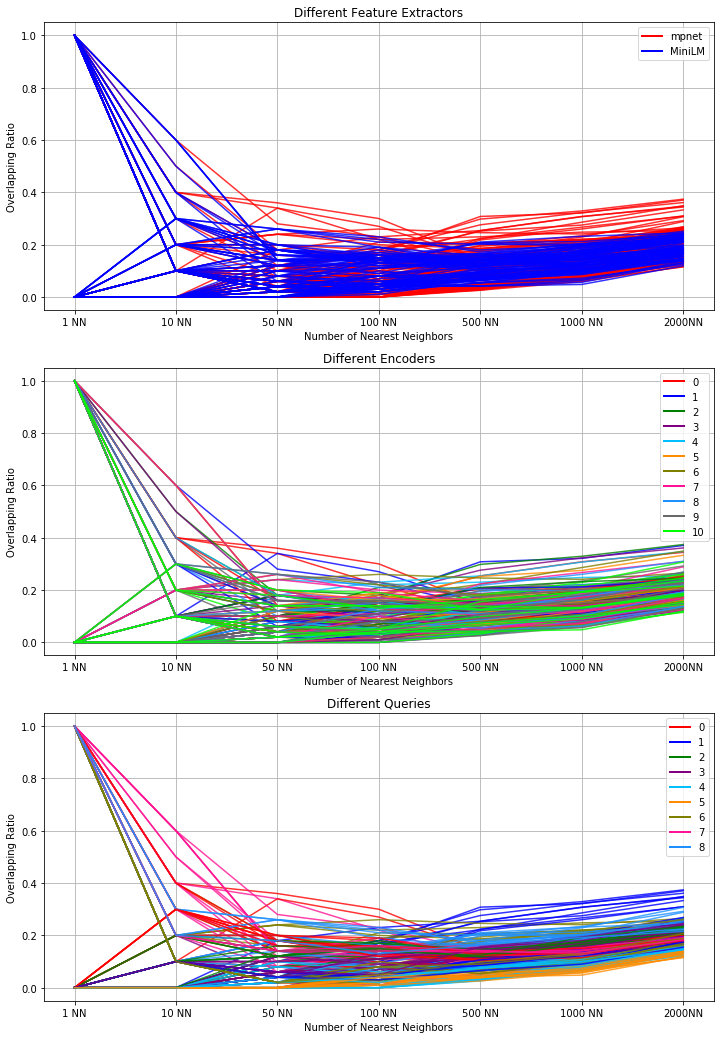

In [47]:
(fig, subplots) = plt.subplots(3, 1, figsize=(12, 6*3))

plt.setp(subplots, xticks=[0, 1, 2, 3, 4, 5, 6], 
         xticklabels=['1 NN', '10 NN', '50 NN', '100 NN', '500 NN', '1000 NN', '2000NN'])
         # yticks=[1, 2, 3])



feature_label_all = [['mpnet', 'MiniLM'],
                     [0,1,2,3,4,5,6,7,8,9,10],
                     [0,1,2,3,4,5,6,7,8]]
title_all = ['Different Feature Extractors', 'Different Encoders', 'Different Queries']


for plot_result in range(0,3):
    ax = subplots[plot_result]
    feature_label = feature_label_all[plot_result]
    feature_color = parameter_all[201:][:,plot_result + 1]

    
    # fig, ax = plt.subplots(figsize = (12,6))


    ax.set_color_cycle(color_all[feature_color])
    ax.set_title(title_all[plot_result])

    g1_plot = ax.plot(intersect_all[201:].T, alpha = 0.8)
    
    g1 = ax.grid()
    g1 = ax.set_xlabel('Number of Nearest Neighbors')
    g1 = ax.set_ylabel('Overlapping Ratio')
    g1 = ax.set_ylim(-0.05, 1.05)

    custom_lines = []
    for i in range(len(feature_label)):
        custom_lines.append(Line2D([0], [0], color=color_all[i], lw=2))

    ax.legend(custom_lines, feature_label)

    # plt.legend(g1_plot,['moved points', 'sss'], loc = 'upper left')



In [115]:
# Calculate mean and median for overlapping ratio

# Feature Extractor
print('---------- Feature Extractor ----------')
for all_idx in [0, 1]:
    print(embedding_list[all_idx])
    int_idx = np.where(parameter_all[201:][:,1] == all_idx)[0]
    print('{0} {1} {2} {3} {4} {5} {6}'.format(*np.around((np.sum(intersect_all[int_idx], axis = 0) / len(int_idx)), 3 )))
    print('{0} {1} {2} {3} {4} {5} {6}'.format(*np.around((np.median(intersect_all[int_idx], axis = 0)), 3 )))

# Encoder
print('---------- Encoder ----------')
for all_idx in range(0,11):
    print(checkpoint_list[all_idx])
    int_idx = np.where(parameter_all[201:][:,2] == all_idx)[0]
    print('{0} {1} {2} {3} {4} {5} {6}'.format(*np.around((np.sum(intersect_all[int_idx], axis = 0) / len(int_idx)), 3 )))
    print('{0} {1} {2} {3} {4} {5} {6}'.format(*np.around((np.median(intersect_all[int_idx], axis = 0)), 3 )))
    

# Query
print('---------- Query ----------')
for all_idx in range(0,9):
    print(query_list[all_idx])
    int_idx = np.where(parameter_all[201:][:,3] == all_idx)[0]
    print('{0} {1} {2} {3} {4} {5} {6}'.format(*np.around((np.sum(intersect_all[int_idx], axis = 0) / len(int_idx)), 3 )))
    print('{0} {1} {2} {3} {4} {5} {6}'.format(*np.around((np.median(intersect_all[int_idx], axis = 0)), 3 )))

    

---------- Feature Extractor ----------
mpnet
0.192 0.24 0.194 0.185 0.295 0.448 0.747
0.0 0.2 0.16 0.14 0.282 0.44 0.746
MiniLM
0.182 0.256 0.199 0.196 0.303 0.452 0.75
0.0 0.1 0.12 0.14 0.308 0.455 0.751
---------- Encoder ----------
0
0.167 0.289 0.25 0.215 0.302 0.445 0.746
0.0 0.25 0.22 0.18 0.284 0.435 0.744
1
0.167 0.239 0.209 0.194 0.302 0.447 0.75
0.0 0.15 0.16 0.155 0.296 0.44 0.75
2
0.222 0.244 0.189 0.189 0.297 0.451 0.75
0.0 0.15 0.12 0.155 0.28 0.455 0.754
3
0.167 0.25 0.203 0.196 0.306 0.45 0.749
0.0 0.15 0.14 0.13 0.29 0.45 0.751
4
0.222 0.244 0.193 0.194 0.303 0.452 0.75
0.0 0.15 0.12 0.125 0.293 0.455 0.751
5
0.167 0.244 0.203 0.201 0.298 0.451 0.749
0.0 0.15 0.15 0.16 0.292 0.45 0.748
6
0.222 0.244 0.19 0.192 0.297 0.452 0.749
0.0 0.15 0.14 0.145 0.286 0.45 0.748
7
0.167 0.25 0.179 0.184 0.295 0.451 0.748
0.0 0.15 0.12 0.14 0.282 0.444 0.748
8
0.222 0.261 0.171 0.172 0.3 0.449 0.747
0.0 0.1 0.09 0.13 0.299 0.443 0.744
9
0.167 0.233 0.183 0.172 0.291 0.45 0.747
0.0 0.

dataset 0
mpnet MiniLM
0 2 8
2 1


dataset 1
mpnet
2 8
5 4






# Case Study

## Case 1&2

In [245]:
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan
from leven import levenshtein       


In [246]:
def lev_metric(x, y):
    data = target_seqs.values.reshape(len(target_seqs.values))
    i, j = int(x[0]), int(y[0])     # extract indices
    return levenshtein(data[i], data[j])

In [262]:
dataset_idx = 0
embedding_idx = 1
checkpoint_idx = 2
query_idx = 1

# ---------- Data Input ----------
query_vector_addr = './new_data/vector/query/features-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] + '.h5'
query_seq_addr = './new_data/sequence/query/feature_seqs-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] +'-'+ str(checkpoint_list[checkpoint_idx]) + '.h5'
target_vector_addr = './new_data/vector/target/targets-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] + '.h5'
target_seq_addr = './new_data/sequence/target/feature_seqs-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] +'-'+ str(checkpoint_list[checkpoint_idx]) + '.h5'

dataset_addr = './new_data/' + dataset_list[dataset_idx] + '-target.json'

with open(dataset_addr, 'r') as f: # snli-target.json
    parsed = json.load(f)
dataset = parsed.copy()
if dataset_idx == 0: # stsb 
    index_list = ['sentence1-{}'.format(i) for i in range(len(dataset) / 2)] + ['sentence2-{}'.format(i) for i in range(len(dataset) / 2)]
else: # snli
    index_list = ['hypothesis-{}'.format(i) for i in range(len(dataset) / 2)] + ['premise-{}'.format(i) for i in range(len(dataset) / 2)]

sentence_all = np.array([dataset[x] for x in index_list])

# # Feature Vector Input
query_text = pd.read_hdf(query_vector_addr).values
target_text = pd.read_hdf(target_vector_addr).values

# # DNA Sequence Input
query_seqs = pd.read_hdf(query_seq_addr)
target_seqs = pd.read_hdf(target_seq_addr)
# print(query_text.shape, target_text.shape, query_seqs.shape, target_seqs.shape)
# e.g., ((9, 768), (2758, 768), (9, 1), (2758, 1))

# ---------- Calculate Distance to Query ----------


# Sequence Edit Distance
query_dis = []
for i in target_seqs.values:
    query_dis.append(levenshteinDistance(query_seqs.values[query_idx][0], i[0]))    
query_dis = np.array(query_dis)

# Feature vector euclidean distance
query_dis_feature = []
for i in target_text:
    query_dis_feature.append(pairwise_distances(query_text[query_idx].reshape(1, -1), 
                                        i.reshape(1, -1), 
                                        metric = 'euclidean')[0][0])
query_dis_feature = np.array(query_dis_feature)



In [263]:
queries = ['A plane is taking off.',
           'A woman is peeling a potato.',
           'The cat is licking a bottle.',
           'Steve Jobs is the CEO of Apple Inc. She hold many dollars of money.',
           'Computer science is one of the most revolutionary fields in scientific research.',
           'The all-* models where trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models.',
           'The church has cracks in the top.',
           'The statue is offensive and people are mad that it is on display.',
           'A group of people are playing in a symphony.']

# {
#         'plane': 'A plane is taking off.',
#         'woman': 'A woman is peeling a potato.',
#         'cat': 'The cat is licking a bottle.',
#         'steve': 'Steve Jobs is the CEO of Apple Inc. She hold many dollars of money.',
#         'CS': 'Computer science is one of the most revolutionary fields in scientific research.',
#         'model': 'The all-* models where trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models.',
#         'church': 'The church has cracks in the top.',
#         'state': 'The statue is offensive and people are mad that it is on display.',
#         'symphony': 'A group of people are playing in a symphony.'
#     }



print(queries[query_idx])



A woman is peeling a potato.


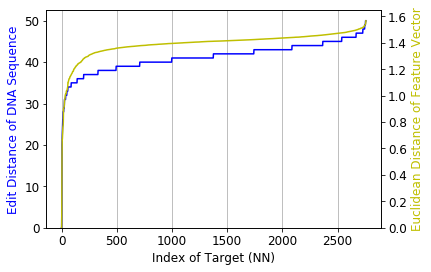

In [264]:
# Plot
fig,ax = plt.subplots()

ax.plot(query_dis[np.argsort(query_dis)], color = 'b') # , label = 'DNA Sequence'
ax.set_ylabel('Edit Distance of DNA Sequence', color = 'b', fontsize = 12)
ax.set_xlabel('Index of Target (NN)', fontsize = 12)
ax.set_ylim(bottom=0)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.grid()
ax.xaxis.grid()


ax2 = ax.twinx()
ax2.plot(query_dis_feature[np.argsort(query_dis_feature)], color = 'y') # , label = 'Feature Vector'
ax2.set_ylabel('Euclidean Distance of Feature Vector', color = 'y', fontsize = 12)
ax2.set_ylim(bottom=0)
ax2.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('case1_new_2.pdf',dpi=600,format='pdf', bbox_inches = 'tight')




In [265]:
# Sentence from DNA sequence, 10NN , 10NN to the query
print(sentence_all[ np.argsort(query_dis)[0:10] ])
# Sentence from feature vectors, 10NN to the query
print(sentence_all[ np.argsort(query_dis_feature)[0:10] ])

[u'A woman is peeling a potato.' u'A woman is peeling a potato.'
 u'A woman is peeling potato.' u'A person is peeling a potato.'
 u'A woman peels garlic with her hands.' u'The lady peeled the potatoe.'
 u'A woman is chopping a peeled potato into slices.'
 u'A woman is dicing some peeled potatoes cut into thick strips.'
 u'A person is peeling a potato with a potato peeler.'
 u'The man is peeling a potato.']
[u'A woman is peeling a potato.' u'A woman is peeling a potato.'
 u'A woman is peeling potato.' u'A person is peeling a potato.'
 u'A person is peeling a potato with a potato peeler.'
 u'A woman is chopping a peeled potato into slices.'
 u'The man is peeling a potato.' u'The man is peeling a potato.'
 u'A man is peeling a potato.' u'The lady peeled the potatoe.']


In [266]:
query_dis

array([40, 48, 40, ..., 44, 40, 41])

In [256]:
query_dis_feature

array([1.3401893, 1.4275833, 1.4494903, ..., 1.422456 , 1.4679934,
       1.4567057], dtype=float32)

In [257]:
np.argsort(query_dis_feature)[0:500]

array([  88, 1607, 1553, 1467, 1597,  218,  174, 1614,  235,  209,   33,
       1412,  603,  122,  349, 1671, 1705,  114, 1500, 1735, 1596, 1665,
       1762, 1691, 1632,  356,  359,  217,  256,  100,  253, 1715,  268,
       1649, 1565,  270, 1738, 1698, 1744, 1638,  513,  262,  286, 1724,
        292,  336,  326,  282,  604, 1641, 1616, 1563,  370, 1749, 1673,
        195,  206, 1579,  412, 1910, 1588,  260,  157, 1661, 1688, 1585,
        101, 1639,  478,  141, 1617,   39, 2040, 1379,  447, 2582, 1857,
       1601, 2405, 1574,  129, 1624, 1203,   85,  405, 1817,  120,  661,
        402, 1603,  442,  184,  620, 1784, 1445,  230,  387,  164,  427,
       2092, 2356,  389, 1494,  238, 1508,   76, 1490,  108,  116,  233,
       1677, 1697,  232, 1805, 1462, 1979, 1609, 1826,  198,  144, 1967,
       1806,  213, 1543,  307, 1431, 1800, 1801,  531, 1123,  288, 1599,
         34, 1622, 1451, 1612, 1570, 1656,   13, 1413, 2404,  561,   16,
         60, 1779, 1439,  124,  422,  398,  344, 17

In [258]:
len(np.argsort(query_dis))

2758

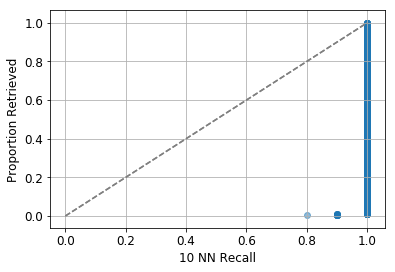

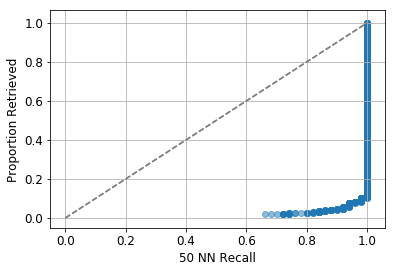

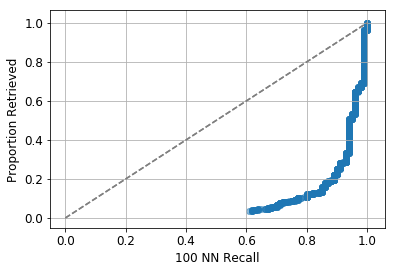

In [267]:
for num_nn in [10, 50, 100]:


    func_100nn = []

    for num_retrieve in range(num_nn,2758):
        func_100nn.append(len(np.intersect1d(np.argsort(query_dis)[0:num_retrieve], np.argsort(query_dis_feature)[0:num_nn])))

    func_100nn = np.array(func_100nn)


    fig, ax = plt.subplots()

    ax.scatter(func_100nn/float(num_nn), np.arange(num_nn,2758)/2758.0, alpha = 0.5)
    std_x = [0,0.5,1]
    std_y = np.array([[0,0], [0.5, 0.5], [1,1]])

    ax.plot(std_x, std_y, '--', color = 'grey')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_xlim(0.005,2)
    # ax.set_ylim(0.0001,2)
    ax.set_xlabel(str(num_nn) + ' NN Recall', fontsize = 12)
    ax.set_ylabel('Proportion Retrieved', fontsize = 12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.grid()
    save_name = 'case1_nn=' + str(num_nn) + '_new_2.jpg'
    plt.savefig(save_name,dpi=600,format='jpg', bbox_inches = 'tight')


    
    

### Clustering (KMeans for feature vectors and DBSCAN (with edit distance) for DNA sequences)

In [ ]:
intersect_tmp = []
for num_k in [1, 10, 50, 100, 500, 1000, 2000]:
    intersect_idx = np.intersect1d(np.argsort(query_dis)[0:num_k], np.argsort(query_dis_feature)[0:num_k])
    intersect_tmp.append(len(intersect_idx)* 1.0/num_k)

In [ ]:
# kmeans_feature = KMeans(n_clusters=100, random_state=0).fit(target_text)
# labels_feature = kmeans_feature.labels_
# embedding = target_text.copy()
# import matplotlib.pyplot as plt

# from matplotlib.ticker import NullFormatter
# from sklearn import manifold, datasets, decomposition
# from time import time


# n_samples = 5000
# n_components = 2
# de_method = 'TSNE'# PCA

# (fig, subplots) = plt.subplots(5, 1, figsize=(8, 8*5))
# perplexities = [5, 30, 50, 100]
# # n_neighbors = [10, 50, 200, 1000]

# # # X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

# X = target_text[0:n_samples,:]
# y = labels_feature[0:n_samples]




# ax = subplots[0]
# ax.scatter(X[:,0], X[:,1], c = y, cmap='viridis')


# # c=t, cmap='viridis'
# # ax.scatter(X[red, 0], X[red, 1], c="r")
# # ax.scatter(X[green, 0], X[green, 1], c="g")
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
# plt.axis('tight')


# if de_method == 'PCA':
#     # ax = subplots[1]
#     ax = fig.add_subplot(projection='3d')

#     t0 = time()
#     pca = decomposition.PCA(n_components=3)
#     Y = pca.fit_transform(X)
#     t1 = time()
#     print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
#     ax.set_title("Perplexity=%d" % perplexity)

#     ax.scatter(Y[:,0], Y[:,1], Y[:,2], c = y, cmap='viridis')
#     ax.xaxis.set_major_formatter(NullFormatter())
#     ax.yaxis.set_major_formatter(NullFormatter())
#     ax.axis('tight')
    
# else:    



#     for i, perplexity in enumerate(perplexities): # T-SNE
#     # for i, neighbor in enumerate(n_neighbors): # LLE

#         ax = subplots[i + 1]

#         t0 = time()
#         tsne = manifold.TSNE(n_components=n_components, init='random',
#                               random_state=0, perplexity=perplexity)

#         # lle = manifold.LocallyLinearEmbedding(n_components=2, n_neighbors = neighbor)
#         Y = tsne.fit_transform(X)
#         # Y = lle.fit_transform(X)

        

#         t1 = time()
#         print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
#         ax.set_title("Perplexity=%d" % perplexity)

#         ax.scatter(Y[:,0], Y[:,1], c = y, cmap='viridis')
#         ax.xaxis.set_major_formatter(NullFormatter())
#         ax.yaxis.set_major_formatter(NullFormatter())
#         ax.axis('tight')


In [ ]:
X = np.arange(len(target_seqs.values.reshape(len(target_seqs.values)))).reshape(-1, 1)
clustering = dbscan(X, eps=0.5, min_samples=3, metric=lev_metric)

In [150]:
for i in np.unique(clustering[1]):
    print('-----')
    print(sentence_all[ np.where(clustering[1] == i) ])

-----
[u'A girl is styling her hair.'
 u'A group of men play soccer on the beach.'
 u"One woman is measuring another woman's ankle." ...
 u'Lawmakers from both sides express outrage at Secret Service'
 u'Myanmar Struggles to Finalize Voter Lists for Sunday Polls'
 u'North Korea Delegation Meets With South Korean Officials']
-----
[u'A man is playing a guitar.' u'A man is playing a guitar.'
 u'A man is playing a guitar.' u'A man is playing a guitar.'
 u'A man is playing a guitar.' u'A man is playing a guitar.'
 u'A man is playing a guitar.' u'A man is playing a guitar.'
 u'A man is playing a guitar.' u'A man is playing a guitar.'
 u'A man is playing a guitar.' u'A man is playing a guitar.'
 u'A man is playing a guitar.']
-----
[u'A woman is cutting tofu.' u'A woman is cutting tofu.'
 u'A woman is cutting tofu.']
-----
[u'A  man is dancing.' u'A man is dancing.' u'A man is dancing.'
 u'A man is dancing.' u'A man is dancing.' u'A man is dancing.']
-----
[u'A woman is cutting an onion.' u'

In [148]:
sentence_all[ clustering[0] ]

array([u'A man is playing a guitar.', u'A man is playing a guitar.',
       u'A man is playing a guitar.', u'A  man is dancing.',
       u'A man is playing a guitar.', u'A man is playing a guitar.',
       u'A man is playing a guitar.', u'A man is playing a guitar.',
       u'A man is playing a guitar.', u'A man is playing a guitar.',
       u'A man is dancing.', u'A man is dancing.',
       u'You just have to base your answer on what you do know, which is what you want.',
       u'You just have to base your answer on what you do know, which is what you want.',
       u"It's not a good idea.", u"You don't have to know.",
       u"It's not a good idea.",
       u'You just have to base your answer on what you do know, which is what you want.',
       u'It depends on what you want to do next, and where you want to do it.',
       u'It depends on what you want to do next, and where you want to do it.',
       u'You just have to base your answer on what you do know, which is what you want.'

## Case 3 (Below is not a perfect case)
Reason: there is few similar items in the dataset to the query

In [ ]:
# Unsucessful due to lack of information in the dataset
# dataset_idx = 1
# embedding_idx = 0
# checkpoint_idx = 2
# query_idx = 5

In [240]:
# dataset_idx = 0
# embedding_idx = 0
# checkpoint_idx = 0
# query_idx = 2
dataset_idx = 1
embedding_idx = 1
checkpoint_idx = 9 #8
query_idx = 5
# 2 8
# 5 4

# ---------- Data Input ----------
query_vector_addr = './new_data/vector/query/features-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] + '.h5'
query_seq_addr = './new_data/sequence/query/feature_seqs-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] +'-'+ str(checkpoint_list[checkpoint_idx]) + '.h5'
target_vector_addr = './new_data/vector/target/targets-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] + '.h5'
target_seq_addr = './new_data/sequence/target/feature_seqs-' + dataset_list[dataset_idx] +'-'+ embedding_list[embedding_idx] +'-'+ str(checkpoint_list[checkpoint_idx]) + '.h5'

dataset_addr = './new_data/' + dataset_list[dataset_idx] + '-target.json'

with open(dataset_addr, 'r') as f: # snli-target.json
    parsed = json.load(f)
dataset = parsed.copy()
if dataset_idx == 0: # stsb 
    index_list = ['sentence1-{}'.format(i) for i in range(len(dataset) / 2)] + ['sentence2-{}'.format(i) for i in range(len(dataset) / 2)]
else: # snli
    index_list = ['hypothesis-{}'.format(i) for i in range(len(dataset) / 2)] + ['premise-{}'.format(i) for i in range(len(dataset) / 2)]

sentence_all = np.array([dataset[x] for x in index_list])

# # Feature Vector Input
query_text = pd.read_hdf(query_vector_addr).values
target_text = pd.read_hdf(target_vector_addr).values

# # DNA Sequence Input
query_seqs = pd.read_hdf(query_seq_addr)
target_seqs = pd.read_hdf(target_seq_addr)
# print(query_text.shape, target_text.shape, query_seqs.shape, target_seqs.shape)
# e.g., ((9, 768), (2758, 768), (9, 1), (2758, 1))

# ---------- Calculate Distance to Query ----------


# Sequence Edit Distance
query_dis = []
for i in target_seqs.values:
    query_dis.append(levenshteinDistance(query_seqs.values[query_idx][0], i[0]))    
query_dis = np.array(query_dis)

# Feature vector euclidean distance
query_dis_feature = []
for i in target_text:
    query_dis_feature.append(pairwise_distances(query_text[query_idx].reshape(1, -1), 
                                        i.reshape(1, -1), 
                                        metric = 'euclidean')[0][0])
query_dis_feature = np.array(query_dis_feature)



In [241]:
print(queries[query_idx])


The all-* models where trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models.


(0, 1.555154550075531)

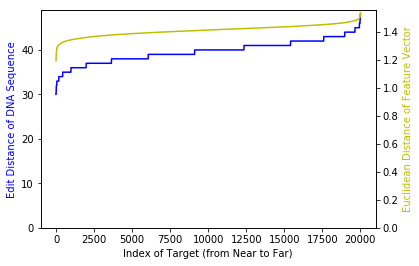

In [242]:
# Plot
fig,ax = plt.subplots()

ax.plot(query_dis[np.argsort(query_dis)], color = 'b') # , label = 'DNA Sequence'
ax.set_ylabel('Edit Distance of DNA Sequence', color = 'b')
ax.set_xlabel('Index of Target (from Near to Far)')
ax.set_ylim(bottom=0)

ax2 = ax.twinx()
ax2.plot(query_dis_feature[np.argsort(query_dis_feature)], color = 'y') # , label = 'Feature Vector'
ax2.set_ylabel('Euclidean Distance of Feature Vector', color = 'y')
ax2.set_ylim(bottom=0)


In [243]:
# Sentence from DNA sequence, 10NN , 10NN to the query
print(sentence_all[ np.argsort(query_dis)[0:10] ])
# Sentence from feature vectors, 10NN to the query
print('=======')
print(sentence_all[ np.argsort(query_dis_feature)[0:10] ])

[u'A man walking a fluffy white dog.'
 u'A man in a white shirt is making a speech in front of a crowd.'
 u'a man walking dogs' u'A group of people march in a parade.'
 u'The girl is sitting on the grass.'
 u'The group of people are flying in the air on their unicorns.'
 u'They are in college.'
 u'A young girl with purple pants, a striped jacket, and a white hat is climbing up a ladder made of logs.'
 u'A young girl with purple pants, a striped jacket, and a white hat is climbing up a ladder made of logs.'
 u'A young girl with purple pants, a striped jacket, and a white hat is climbing up a ladder made of logs.']
[u'The woman is a super model.' u'They are wearing all black gear.'
 u'lessons are there to learn' u'People in the military are training.'
 u'The woman is a model.'
 u'Luchadores force all other athletes off a competition field with their furious grappling.'
 u'Everyone is riding rollerblades.'
 u'The woman posing is a famous model.' u'The children can all swim.'
 u'An elephan

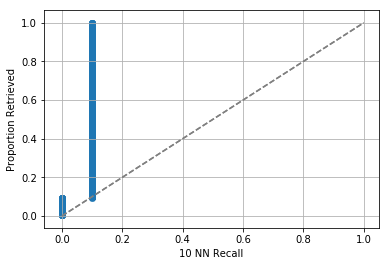

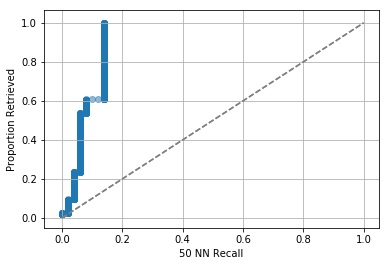

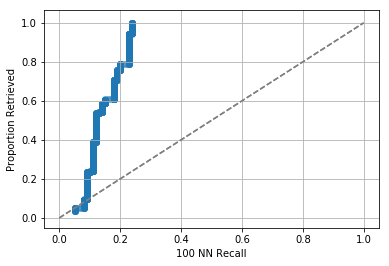

In [244]:
for num_nn in [10, 50, 100]:


    func_100nn = []

    for num_retrieve in range(num_nn,2758):
        func_100nn.append(len(np.intersect1d(np.argsort(query_dis)[0:num_retrieve], np.argsort(query_dis_feature)[0:num_nn])))

    func_100nn = np.array(func_100nn)


    fig, ax = plt.subplots()

    ax.scatter(func_100nn/float(num_nn), np.arange(num_nn,2758)/2758.0, alpha = 0.5)
    std_x = [0,0.5,1]
    std_y = np.array([[0,0], [0.5, 0.5], [1,1]])

    ax.plot(std_x, std_y, '--', color = 'grey')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_xlim(0.005,2)
    # ax.set_ylim(0.0001,2)
    ax.set_xlabel(str(num_nn) + ' NN Recall')
    ax.set_ylabel('Proportion Retrieved')
    ax.grid()

    
    

### Clustering

In [176]:
X = np.arange(len(target_seqs.values.reshape(len(target_seqs.values)))).reshape(-1, 1)
clustering = dbscan(X, eps=0.5, min_samples=3, metric=lev_metric)



In [177]:
for i in np.unique(clustering[1]):
    print('-----')
    print(sentence_all[ np.where(clustering[1] == i) ])

-----
[u'The church has cracks in the ceiling.'
 u'The church is filled with song.' u'A choir singing at a baseball game.'
 ... u'A man is speaking in a classroom.'
 u'A man is teaching science in a classroom.'
 u'A cowboy is showing off his mule next to a horse hauling trailer.']
-----
[u'The man is inside.' u'The man is inside.' u'The man is inside.']
-----
[u'There are people outside.' u'There are people outside.'
 u'There are people outside.' u'There are people outside.'
 u'There are people outside.' u'There are people outside.']
-----
[u'People are outdoors.' u'People are outdoors.' u'People are outdoors.']
-----
[u'the man is at home sleeping' u'the man is at home sleeping'
 u'the man is at home sleeping' u'the man is at home sleeping'
 u'the man is at home sleeping' u'the man is at home sleeping']
-----
[u'A man is swimming in the ocean.' u'A man is swimming in the ocean.'
 u'A man is swimming in the ocean.']
-----
[u'The woman is standing.' u'The woman is standing.'
 u'The woma

In [178]:
sentence_all[ clustering[0] ]

array([u'The man is inside.', u'There are people outside.',
       u'People are outdoors.', ...,
       u'A man in a black leather jacket and a book in his hand speaks in a classroom.',
       u'A man in a black leather jacket and a book in his hand speaks in a classroom.',
       u'A man in a black leather jacket and a book in his hand speaks in a classroom.'],
      dtype='<U265')